# Problem Definition

The goal of the challenge is to help the HR team in making the hiring process more efficient by deriving the final decision by applying machine learning on the data collected during the interview process.

The aproach has two-folds:
1. Deriving variables E, N. A, C and O.

    Using the variables V and Q which are collected during the interview process we have to derive these five variables which are actually a five personality traints. From the given dataset we can see that they are scores from 1 to 100. Since there are five numeric target variables it is a multioutput/multitarget regression problem.

2. Deriving variable H.

    H is a final decision and it has two classes **yes** and **no** hence it is a binary classification problem. We derive this variable using the variables we derived in the step 1.
    

## Exploratory Data Analysis

In [253]:
# Issue with the pandas profiling report in order to fix the issues latest version of pyarrow is installed
!pip3 install pandas_profiling
!pip3 install pyarrow
!pip3 install xgboost
!pip3 install imblearn
!pip3 install tdqm
!pip3 install joblib
!pip3 install prince

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas_profiling import ProfileReport
from collections import Counter

from scipy import stats

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import copy
from tqdm import tqdm
import multiprocessing

import joblib

# Data preperation
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# model selection
from sklearn import model_selection

#Estimators
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression


#Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score,roc_auc_score

# tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

np.random.seed(42)
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
# Reading the dataset
df = pd.read_csv("data.csv")

# Usage of metrics

1. Mean squarred error(MSE): n [0,∞), the smaller the better.
Measures the mean square magnitude of errors. Root square is taken to make the units of the error be the same as the units of the target. This measure gives more weight to large deviations such as outliers, since large differences squared become larger and small (smaller than 1) differences squared become smaller.


2. Mean absolute error(MAE): Measures additive bias in the error. Unbiased estimates should have the same mean as your target thus ME should be close to 0, if it's positive your predictions overestimate the target, if it's negative they underestimate.

3. Mean squarred log error(MSLE): n [0,∞), the smaller the better.
This is useful when dealing with right skewed targets, since taking the log transform makes the target more normally distributed. In practice it's usually achieved by changing the target to y^=log(y+1) and then predicting as y=ey^−1

4. Median Absolute Deviation(MAD) :n [0,∞), the smaller the better.
This is a spread metric similar to standard deviation but meant to be more robust to outliers. Instead of taking means of squares as the sd, MAD takes medians of absolutes making it more robust.

5. R² or coefficient of determinant: In (−∞,1] the closer to 1 the better Is a measure of the ratio of variability that your model can capture vs the natural variability in the target variable.

* Skeness: It tells the symmetry of the distribution. if the distribution is right skewed then mean > median > mode and if the distribution is left skewed then mode > median > mean

* Kustosis: It referes to the degree of presense of outliers
    * k > 3 then Leptokurtic --> more outliers
    * k == 3 then mesokurtic --> normal distribution
    * k < 3 then Platikurtic --> less outliers and data distributed within the high proximity of mean

ROC Curve: An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

    * True Positive Rate
    * False Positive Rate

### Pandas profiling

I am using pandas profiling to understand more about the data such as type of variables, missing values, correlations etc.

In [146]:
def profiling_report(df):
    """
    Profiling report generating takes more memory so taking smaller sample before I run.
    Also we can use 'minimal=True' to generate only the minimal report.
    
    """
    df = df.sample(n=100, random_state=1)
    return df.profile_report(pool_size=6, title="Profile Report")

In [76]:
profiling_report(df)

Summarize dataset:   0%|          | 0/78 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Create Testset

Before we go deep into the dataset, I prepare the testset so that we don't get biased from the test data in model building process.

In [10]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [147]:
def detect_outlier(x: pd.Series):
    print(f"Stats on original feature: Min - {np.min(x)}, Max - {np.max(x)}, Median - {np.median(x)} Std - {np.std(x)}, Mean - {np.mean(x)}")
    z = (x - x.mean())/x.std(ddof=0)
    print(f"Stats on trsnsformed feature: Min - {np.min(z)}, Max - {np.max(z)}, Median - {np.median(z)} Std - {np.std(z)}, Mean - {np.mean(z)}")
    print(np.where(z>=3))
    sns.boxplot(x=x)

Use z-score and other statistical measure to detect if there are outliers in the features. 
1. If there are outliers remove the outliers from the dataset.
2. Apply standardization or Normalization in case of data has too much variane. 

Stats on original feature: Min - 13, Max - 999999999, Median - 22.0 Std - 7961622.122069654, Mean - 63450.861299524564
Stats on trsnsformed feature: Min - -0.007967956821722863, Max - 125.59457517669316, Median - -0.007966826398818837 Std - 0.9999999999999561, Mean - 2.2654619859936326e-16
(array([2068]),)


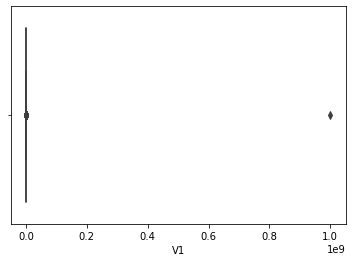

In [79]:
detect_outlier(train_set["V1"])

With our outlier detection technique we found that there is one outlier in the feature V1 has outlier at index `4004` so we remove the row while data cleaning

In [80]:
ordinal_variables = [c for c in list(df) if len(df[c].unique()) <=7]
targets_numerical = ["E", "N", "A", "C", "O"]
target_binary = ["H"]
numerical_variables = list(set(df.columns) - set(ordinal_variables) - set(targets_numerical) - set(target_binary) - {"id"}) 

In [81]:
# Describing the target variables for multioutput regression model
df[targets_numerical].describe()


E             N             A             C             O
count  19719.000000  19719.000000  19719.000000  19719.000000  19719.000000
mean      50.090471     57.804605     68.774989     58.790253     72.065166
std       18.439632     17.246564     14.366701     14.622259     12.612788
min       10.000000     16.000000     12.000000     12.000000     13.000000
25%       36.000000     46.000000     60.000000     48.000000     64.000000
50%       50.000000     57.000000     70.000000     60.000000     74.000000
75%       64.000000     70.000000     80.000000     70.000000     82.000000
max       90.000000     96.000000     92.000000     92.000000     94.000000

In [82]:
def distribution_plot(df, features):
    fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20, 5))

    for i, ax in zip(features, axes.flat):
        sns.distplot(df[i], hist=True, ax=ax)
    plt.show()

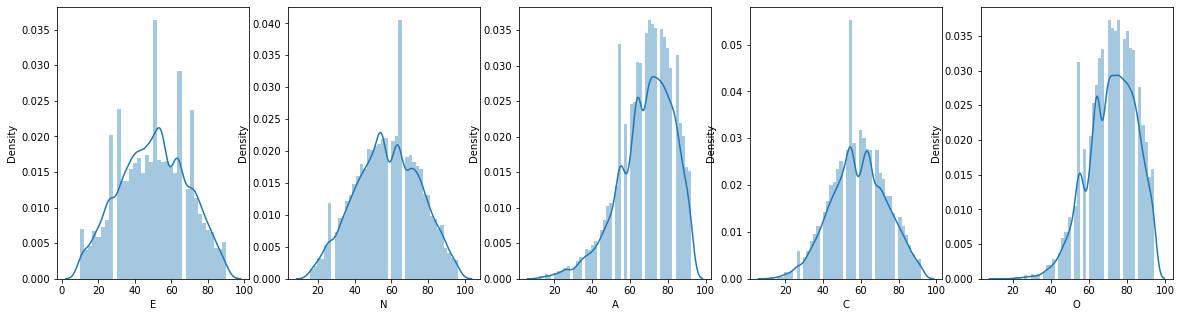

In [83]:
distribution_plot(train_set, targets_numerical)

<AxesSubplot:>

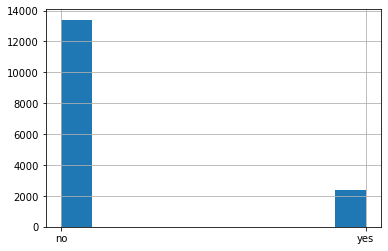

In [84]:
train_set.H.hist()

In [85]:
def check_skewness_kurtosis(df, features):
    for target in features:
        #skewness and kurtosis
        print("Skewness: %f" % df[target].skew())
        print("Kurtosis: %f" % df[target].kurt())

In [86]:
check_skewness_kurtosis(df, ['V0'])

Skewness: 1.033249
Kurtosis: -0.624581


In [87]:
def correlation_matrix(df):
    #correlation matrix
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(corrmat, vmax=.8, square=True);
    return corrmat

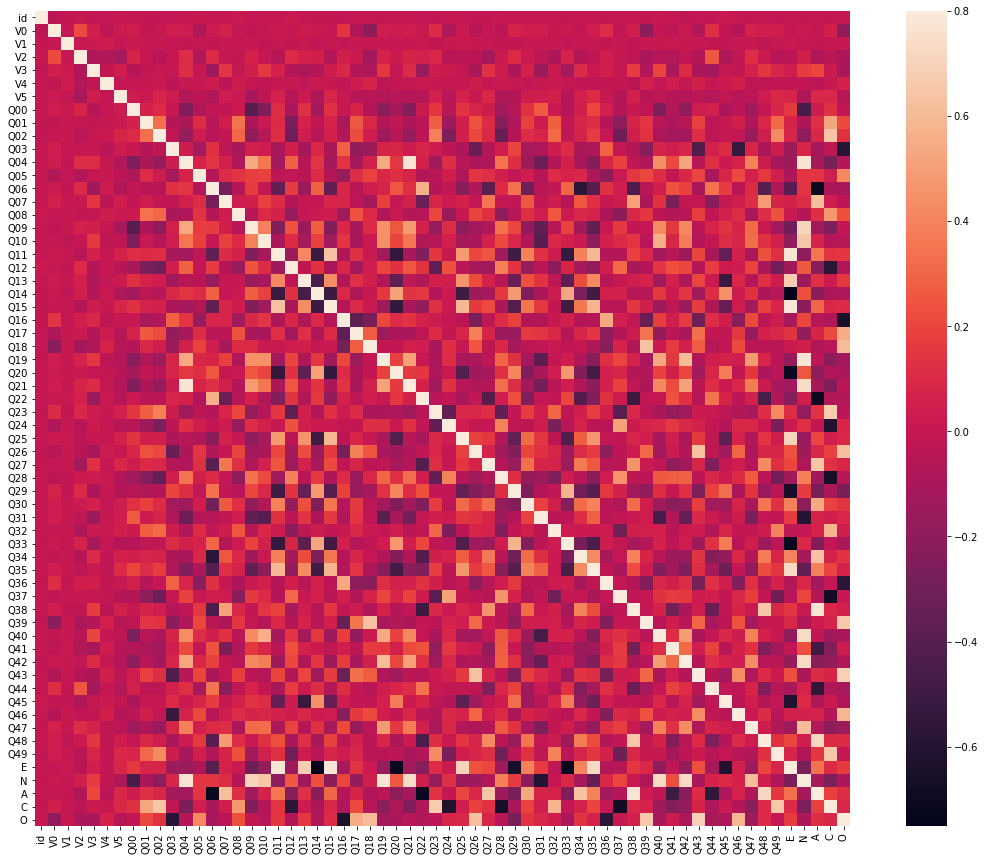

In [88]:
corrmat = correlation_matrix(df)

In [89]:
top_correlations = corrmat[["A", "E", "N", "C", "O"]].sort_values(by="O", ascending=False)

In [90]:
top_correlations.head(15)

A         E         N         C         O
O    0.117063  0.165987 -0.100218  0.086191  1.000000
Q43  0.105171  0.228120 -0.092045  0.073884  0.686768
Q39  0.026208  0.093734 -0.077929  0.068542  0.655701
Q26  0.085971  0.240165 -0.144275  0.177084  0.619466
Q18 -0.074691  0.024045  0.052464 -0.046539  0.611238
Q46  0.070177  0.056886  0.063904 -0.057804  0.585124
Q17  0.073879  0.136428 -0.178798  0.209377  0.546604
Q05  0.144013 -0.090443  0.143331  0.037429  0.418053
Q08  0.117888  0.014488 -0.061957  0.471132  0.235055
Q01  0.125011  0.075680 -0.090766  0.523495  0.215072
E    0.334002  1.000000 -0.262849  0.106125  0.165987
Q13  0.125077  0.673424 -0.136765  0.027025  0.155649
Q11  0.352495  0.775414 -0.189876  0.144799  0.148080
Q30  0.533263  0.392911 -0.204764  0.190689  0.137090
Q34  0.633965  0.406014 -0.120902  0.070948  0.134921

Based on the correlation analysis of individual target, correlated feature set is different for each target variable.

In [91]:
#scatter plot to understand the coorelation with target variables
def scatter_plot(df, target, feature):
    data = pd.concat([df[target], df[feature]], axis=1)
    data.plot.scatter(x=feature, y=target, ylim=(0,100))

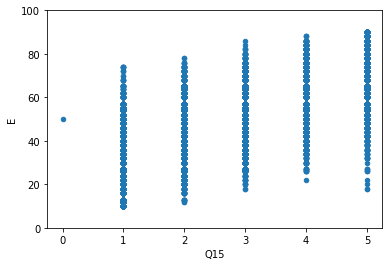

In [92]:
scatter_plot(df, 'E', 'Q15')

## Findings from Exploratory Data Analysis

After taking the deep look into the dataset, following are the findings.

1. Variable `V1` has some outliers we can clearly see from Median - 22.0 and Mean - 63450.861299524564. This feature has no correlation with any of the target variables.
2. Most of the features have missing values.
3. Dataset has mostly the ordinal variables which have imbalance in the distributions, we should fill the missing vaulaes using the most frequent ordinal value.
4. Variable `V6` has 154 unique country codes most of which have fewer representations, More than 50% of the samples covered by just 5 countries.
5. Differnt set of features have correlation to different target variable but not to all the target variables.
7. Final target variable H is highly imbalanced. 

# Data cleaning and pre-processing

In [4]:
# Onehot encoding for the column V6 with merging less frequent categories into `other` column

class GroupingTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, *, min_count=0, min_freq=0.0, top_n=0, group_name='other'):
        self.min_count = min_count
        self.min_freq = min_freq
        self.top_n = top_n
        self.group_name='other'
        
    def fit(self, X, y=None):
        n_samples, n_features = X.shape
        counts = []
        groups = []
        other_in_keys = []
        for i in range(n_features):
            cnts = Counter(X[:, i])
            counts.append(cnts)
            if self.top_n == 0:
                self.top_n = len(cnts)
            labels_to_group = (label for rank, (label, count) in enumerate(cnts.most_common())
                                 if ((count < self.min_count) 
                                 or (count/n_samples < self.min_freq)
                                 or (rank >= self.top_n)
                                    )
                              )
            groups.append(np.array(sorted(set(labels_to_group))))
            other_in_keys.append(self.group_name in cnts.keys())
        self.counts_ = counts
        self.groups_ = groups
        self.other_in_keys_ = other_in_keys
        return self
    
    def transform(self, X):
        X_t = X.copy()
        _, n_features = X.shape
        for i in range(n_features):
            mask = np.isin(X_t[:, i], self.groups_[i])
            X_t[mask, i] = self.group_name
        return X_t

Reducing number of country code for variable `V6` by grouping less represented country codes into others and onHotEncoding. Before applying group transformation, I am replacing the missing values with constant value `other`.

In [30]:
def pre_process(X, top_n=10):
    numerical_features = ['V0', 'V4']
    ordinal_features = [column for column in df.columns if column.startswith("Q")] + ['V2', 'V3', 'V4', 'V5']
    targets_reg = ['E', 'N', 'A', 'C', 'O']
    target_cls = ['H']
    
    transform_v6 = Pipeline(steps=[('fillna', SimpleImputer(strategy='constant', fill_value='other')),
                                  ('groupTransform', GroupingTransformer(top_n=top_n)),
                                  ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    
    column_transforms = ColumnTransformer(transformers=
                [('drop_id', 'drop', ['id', 'V1']),
                 ('process_v6', transform_v6, ['V6']),
                 ('fillna_numerical', SimpleImputer(strategy="median"), numerical_features ),
                 ('fillna_v_features', SimpleImputer(strategy="most_frequent"), ordinal_features )
                 ],
                 remainder='passthrough')
    data = column_transforms.fit_transform(X)
    v6_columns = column_transforms.named_transformers_["process_v6"].steps[2][1].get_feature_names()
    v6_columns = [column.replace('x0', 'V6') for column in v6_columns]
    features = list(v6_columns) + numerical_features + ordinal_features
    X_new = pd.DataFrame(data, columns = features + targets_reg + target_cls)
    X_new['H'] = X_new.H.replace({"yes": 1, "no": 0})
    return X_new

In [31]:
def create_folds(X):
    X["kfold"] = -1
    X = X.sample(frac=1).reset_index(drop=True)

    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X=X, y=X.H.values)):
        X.loc[val_idx, 'kfold'] = fold
    
    X.to_csv('train_folds.csv', index=False)

In [32]:
X_train_reg = pre_process(train_set)
create_folds(X_train_reg)

## Data Preparation for ML model

In [107]:
def get_train_data_regression(fold, model_type='regression'):
    FOLD_MAPPPING = {
        0: [1, 2, 3, 4],
        1: [0, 2, 3, 4],
        2: [0, 1, 3, 4],
        3: [0, 1, 2, 4],
        4: [0, 1, 2, 3]
    }
    targets_reg = ['E', 'N', 'A', 'C', 'O']
    target_cls = ['H']
    df = pd.read_csv('train_folds.csv')
    train_df = df[df.kfold.isin(FOLD_MAPPPING.get(fold))].reset_index(drop=True)
    valid_df = df[df.kfold==fold].reset_index(drop=True)
    if model_type == "regression":
        ytrain = train_df[targets_reg].values
        yvalid = valid_df[targets_reg].values

        train_df = train_df.drop(["kfold"] + targets_reg + target_cls , axis=1)
        valid_df = valid_df.drop(["kfold"] + targets_reg + target_cls , axis=1)
    elif model_type == "classification":
        ytrain = train_df.H.values
        yvalid = valid_df.H.values

        train_df = train_df[targets_reg]
        valid_df = valid_df[targets_reg]
    else:
        raise ValueError("Type not supported")
    
    return (train_df, valid_df, ytrain, yvalid)

In [109]:
get_train_data_regression()
def get_test_data(model_type='regression'):
    test_df = pre_process(test_set)
    targets_reg = ['E', 'N', 'A', 'C', 'O']
    target_cls = ['H']
    if model_type == 'regression':
        X_test = test_df.drop(targets_reg + target_cls , axis=1)
        Y_test = test_df[targets_reg]
    elif model_type == 'classification':
        X_test = test_df[targets_reg]
        Y_test = test_df[target_cls]
    else:
        raise TypeError("Type not supported")
    return (X_test, Y_test)

### Visualize the data by doing MCA

In [271]:
import prince
X, *rest = get_train_data_regression(0)
mca = prince.MCA()
data = mca.fit_transform(X[['V2', 'V3', 'V4', 'V5']])


ZeroDivisionError: float division by zero

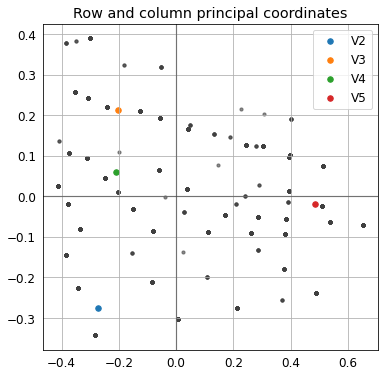

In [274]:
ax = mca.plot_coordinates(
     X=X[['V2', 'V3', 'V4', 'V5']],
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
     )

## Model Train and Evaluation

### Model - 1 to predict E, N, A, C and O

We understood the problem and explored data using various approaches and applied all the findings from the exploratory data analysis and prepared the dasetset that can be feeded to models.

This is multioutput/multitarget regression problem, only some models  like KNN, LinearRegression, DecisionTreeRegression etc,. supports multirarget regression out of the box. To use other models we have to use the wrapper class **MultiOutputRegressor**. Also the dataset has many categorical/ordinal features we have to use models which perform better on these types.
Based on the intuition and the past experience, I choose below models to start experment with, later I tweak the model based on the performance.

    1. LinearRegression and Ridge
    2. DecisionTreeRegresson
    3. SVR and Linear SVR
    4. RandomForest
    5. XGBRegressor
    
Since the dataset is small, I sart using **StratiFiedKFold** croos validation from the begining.



In [16]:
def train_regression_model(model):
    mse_valid = []
    r2_valid = []
    mae_valid = []
    mse_train = []
    r2_train = []
    mae_train = []
    for fold in tqdm(range(5)):
        train_df, valid_df, ytrain, yvalid = get_train_data_regression(fold)
        model.fit(train_df, ytrain)
        y_pred = model.predict(valid_df)
        mse_valid.append(mean_squared_error(yvalid, y_pred))
        r2_valid.append(r2_score(yvalid, y_pred))
        mae_valid.append(mean_absolute_error(yvalid, y_pred))
        y_pred_train = model.predict(train_df)
        mse_train.append(mean_squared_error(ytrain, y_pred_train))
        r2_train.append(r2_score(ytrain, y_pred_train))
        mae_train.append(mean_absolute_error(ytrain, y_pred_train))
    print(f"Mean MSE validation set: {sum(mse_valid)/len(mse_valid)}")
    print(f"Mean R2-score validation set: {sum(r2_valid)/len(r2_valid)}")
    print(f"Mean MAE validation set: {sum(mae_valid)/len(mae_valid)}")
    print(f"Mean MSE train set: {sum(mse_train)/len(mse_train)}")
    print(f"Mean R2-score train set: {sum(r2_train)/len(r2_train)}")
    print(f"Mean MAE train set: {sum(mae_train)/len(mae_train)}")
    compare_predictions(yvalid[:5], y_pred[:5])

In [22]:
def compare_predictions(Y_true, Y_pred):
    for i, j in zip(Y_true, Y_pred):
        print(i, j)
        print(np.subtract(i, j))

## LinearRegression and Ridge

Linear regression performs fairly well already and doesn't seems to be overfitting but just trying with regularized model to check if is there an effect of regularization.
It doesn't seems to be the case, I stick with the LinearRegression model

In [39]:
cpu_count = multiprocessing.cpu_count()

In [35]:
#model = Ridge()
model = LinearRegression()
train_regression_model(model)

100%|██████████| 5/5 [00:00<00:00,  6.46it/s]

Mean MSE validation set: 4.256794601586266
Mean R2-score validation set: 0.9818968357670567
Mean MAE validation set: 1.338273198000182
Mean MSE train set: 4.206550156515078
Mean R2-score train set: 0.9821171006750509
Mean MAE train set: 1.3308368939153836
[74 78 84 64 72] [74.56589502 76.82251045 83.4787793  67.93312687 71.26575707]
[-0.56589502  1.17748955  0.5212207  -3.93312687  0.73424293]
[40 34 55 80 57] [39.27317041 33.18066475 55.30360841 80.34297795 57.1673684 ]
[ 0.72682959  0.81933525 -0.30360841 -0.34297795 -0.1673684 ]
[84 46 76 72 64] [84.74152368 43.34643623 75.39601563 72.03685612 67.02149437]
[-0.74152368  2.65356377  0.60398437 -0.03685612 -3.02149437]
[27 36 76 80 86] [31.91834253 35.21337959 75.49226807 80.47426457 85.67652367]
[-4.91834253  0.78662041  0.50773193 -0.47426457  0.32347633]
[50 34 46 46 82] [60.56006616 33.55127022 44.46083497 45.34676213 81.7545266 ]
[-10.56006616   0.44872978   1.53916503   0.65323787   0.2454734 ]


### Decision Tree

In [475]:
model = DecisionTreeRegressor()
train_regression_model(model)


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

Mean MSE validation set: 152.91364817749601
Mean R2-score validation set: 0.3276309381613256
Mean MAE validation set: 9.621527733755944
Mean MSE train set: 0.0
Mean R2-score train set: 1.0
Mean MAE train set: 0.0


MSE is 0 on the training set and 152 on the validatoinset which clearly shows the model is perfectly overfitting the training data. 

## Linear SVR


In [41]:
model = MultiOutputRegressor(LinearSVR(tol=1e-5))
train_regression_model(model)

100%|██████████| 5/5 [01:15<00:00, 15.02s/it]

Mean MSE validation set: 4.8302646222931
Mean R2-score validation set: 0.9792386374301202
Mean MAE validation set: 1.1261750588444772
Mean MSE train set: 4.830611572596907
Mean R2-score train set: 0.9792495596561421
Mean MAE train set: 1.126055519479816
[74 78 84 64 72] [73.99793753 76.01557871 83.93878066 68.05365011 72.01244426]
[ 2.06247197e-03  1.98442129e+00  6.12193439e-02 -4.05365011e+00
 -1.24442605e-02]
[40 34 55 80 57] [39.92291155 34.00315874 55.9707125  80.08832448 57.93596205]
[ 0.07708845 -0.00315874 -0.9707125  -0.08832448 -0.93596205]
[84 46 76 72 64] [84.01067292 43.99708279 75.89656021 72.06219866 67.98999333]
[-0.01067292  2.00291721  0.10343979 -0.06219866 -3.98999333]
[27 36 76 80 86] [31.91016665 35.98420318 75.89437924 80.12921609 86.03036349]
[-4.91016665  0.01579682  0.10562076 -0.12921609 -0.03036349]
[50 34 46 46 82] [60.01492742 34.0211586  45.77009401 46.17915701 82.08512397]
[-10.01492742  -0.0211586    0.22990599  -0.17915701  -0.08512397]


## SVR

In [42]:
model = MultiOutputRegressor(SVR(kernel='linear'), n_jobs=4)
train_regression_model(model)

100%|██████████| 5/5 [09:22<00:00, 112.46s/it]

Mean MSE validation set: 4.778359961818395
Mean R2-score validation set: 0.9794611807726641
Mean MAE validation set: 1.1227559729609085
Mean MSE train set: 4.776572396841239
Mean R2-score train set: 0.9794740027466325
Mean MAE train set: 1.122381074632099
[74 78 84 64 72] [73.99212978 76.03888412 83.89999005 67.90013587 71.8998884 ]
[ 0.00787022  1.96111588  0.10000995 -3.90013587  0.1001116 ]
[40 34 55 80 57] [39.91162734 33.87495036 55.89998489 79.90007393 57.89983932]
[ 0.08837266  0.12504964 -0.89998489  0.09992607 -0.89983932]
[84 46 76 72 64] [84.04602499 43.91201377 75.89993607 71.90027209 67.89992706]
[-0.04602499  2.08798623  0.10006393  0.09972791 -3.89992706]
[27 36 76 80 86] [31.95762496 35.89874865 75.89995161 79.90014736 85.8999228 ]
[-4.95762496  0.10125135  0.10004839  0.09985264  0.1000772 ]
[50 34 46 46 82] [60.02592726 33.93060636 45.89994124 45.89988504 81.90022312]
[-10.02592726   0.06939364   0.10005876   0.10011496   0.09977688]


### Random Forest

In [478]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=10,
                                                          random_state=0))
train_regression_model(model)



100%|██████████| 5/5 [02:37<00:00, 31.58s/it]

Mean MSE validation set: 12.652006277317463
Mean R2-score validation set: 0.9451627179718025
Mean MAE validation set: 2.647270661982205
Mean MSE train set: 6.101545651753236
Mean R2-score train set: 0.9735129071806672
Mean MAE train set: 1.9171492168410615


## XGBoost

In [479]:
model = MultiOutputRegressor(XGBRegressor(objective='reg:linear', 
                                           n_estimators=600,
                                           max_depth=6))
train_regression_model(model)

  0%|          | 0/5 [00:00<?, ?it/s]

[01:09:00] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:04] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:17] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


 20%|██        | 1/5 [00:27<01:48, 27.02s/it]

[01:09:27] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:31] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:36] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:45] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 2/5 [00:51<01:15, 25.24s/it]

[01:09:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:09:55] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:01] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


 60%|██████    | 3/5 [01:31<01:04, 32.09s/it]

[01:10:31] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:50] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:11:02] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


 80%|████████  | 4/5 [02:07<00:33, 33.81s/it]

[01:11:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:11:14] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:11:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:11:33] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:11:45] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 5/5 [02:57<00:00, 35.50s/it]

Mean MSE validation set: 6.994504611911083
Mean R2-score validation set: 0.9699495444571383
Mean MAE validation set: 1.9334635718839859
Mean MSE train set: 0.02500697494213583
Mean R2-score train set: 0.9998939032731107
Mean MAE train set: 0.095863654522057


### Model improvment


Already, I have experimented with couple of models out of which some of the models are performing well already without any finetuning. Models can be still fine tuned using some of the following techniques.
1. Further tuning the hyperparameters using GridSearchCV or RandomizedSearchCV. 
2. Ensemble multiple models using stacking or blending.
3. Can also try with Neural Networks



In [ ]:
# Tuning parameters for SVR
param_grid = [{'estimator__kernel': ['rbf', 'linear', 'ploy'], 'estimator__tol': [1e-3, 1e-4, 1e-5]}]
model = SVR()
random_search = RandomizedSearchCV(MultiOutputRegressor(model), param_grid, cv=5)
train_df, valid_df, ytrain, yvalid = get_train_data_regression(0)
random_search.fit(np.vstack((train_df,valid_df)) , np.vstack((ytrain, yvalid)))

In [244]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.linear2 = nn.Linear(output_size, 5)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        out = self.linear1(X)
        self.relu(out)
        out = self.linear2(out)
        return out
        

In [161]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        

In [182]:
train_df, valid_df, ytrain, yvalid = get_train_data_regression(0)
train_data = CustomDataset(train_df.to_numpy(), ytrain)
valid_data = CustomDataset(valid_df.to_numpy(), yvalid)
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(valid_data, batch_size=64)

In [222]:
output_dim = 30
input_dim = 67
epochs = 10
learning_rate = 1e-3

In [245]:
model = LinearRegression(input_dim, output_dim)
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterian = nn.MSELoss()

In [246]:
for epoch in range(10):
    tk0 = tqdm(train_loader, total=len(train_loader))
    for idx, (data, labels) in enumerate(tk0):
        #print(labels.shape)
        optim.zero_grad()
        out = model(data.float())
        loss = criterian(out, labels.float())
        loss.backward()
        optim.step()
    print(f"training epoch: {epoch} with the loss {loss.item()}")

100%|██████████| 198/198 [00:00<00:00, 925.58it/s]


training epoch: 0 with the loss 775.3308715820312


100%|██████████| 198/198 [00:00<00:00, 1175.64it/s]


training epoch: 1 with the loss 520.7745361328125


100%|██████████| 198/198 [00:00<00:00, 1239.33it/s]


training epoch: 2 with the loss 44.36982345581055


100%|██████████| 198/198 [00:00<00:00, 1350.84it/s]


training epoch: 3 with the loss 34.96943283081055


100%|██████████| 198/198 [00:00<00:00, 1290.26it/s]


training epoch: 4 with the loss 1286.25


100%|██████████| 198/198 [00:00<00:00, 1227.60it/s]


training epoch: 5 with the loss 1207.332763671875


100%|██████████| 198/198 [00:00<00:00, 1283.75it/s]


training epoch: 6 with the loss 956.6346435546875


100%|██████████| 198/198 [00:00<00:00, 1205.87it/s]


training epoch: 7 with the loss 1105.24755859375


100%|██████████| 198/198 [00:00<00:00, 958.76it/s] 


training epoch: 8 with the loss 996.1624145507812


100%|██████████| 198/198 [00:00<00:00, 1049.78it/s]

training epoch: 9 with the loss 925.8847045898438


In [251]:
with torch.no_grad(): # we don't need gradients in the testing phase
    mse_valid = []
    r2_valid = []
    mae_valid = []
    tk0 = tqdm(train_loader, total=len(val_loader))
    for idx, (data, labels) in enumerate(tk0):
        predicted = model(data.float())
        mse_valid.append(mean_squared_error(labels.float(), predicted))
        r2_valid.append(r2_score(labels.float(), predicted))
        mae_valid.append(mean_absolute_error(labels.float(), predicted))
    print(f"Mean MSE validation set: {sum(mse_valid)/len(mse_valid)}")
    print(f"Mean R2-score validation set: {sum(r2_valid)/len(r2_valid)}")
    print(f"Mean MAE validation set: {sum(mae_valid)/len(mae_valid)}")
        



198it [00:00, 671.03it/s]             

Mean MSE validation set: 349.66238495797825
Mean R2-score validation set: -0.5916091367350282
Mean MAE validation set: 18.166954242821895


### Evaluate model on the testset

LinearRegression model is performing already well so I just use this model to test on the testset I created in the begining. I am choosing this model because it is simple and less training time.

In [112]:
model = LinearRegression()
train_df, valid_df, ytrain, yvalid = get_train_data_regression(0)
model.fit(np.vstack((train_df,valid_df)) , np.vstack((ytrain, yvalid)))
X_test, Y_test = get_test_data('regression')
Y_pred = model.predict(X_test)

print(f"MSE testset: {mean_squared_error(Y_test, Y_pred)}")
print(f"R2 score test: {r2_score(Y_test, Y_pred)}")
print(f"MAE test: {mean_absolute_error(Y_test, Y_pred)}")

# save model and predictions
joblib.dump(model, "linear_regression.pkl")
joblib.dump(X_test.columns, "linear_regression_columns.pkl")
joblib.dump(Y_pred, "linear_regression_predictions.pkl")


MSE testset: 4.537062848805998
R2 score test: 0.9803352918734838
MAE test: 1.3950993522652897


['linear_regression_predictions.pkl']

## Model-2 to predict classes in H

Here, we have five features and a binary target variables hence I model it as binary classification problem.
I am choosing LogisticRegression to baseline and directly use XGBoostClassifier it works pretty well on variety of datasets.

In [ ]:
def random_over_sampling(X, y):
    ros = RandomOverSampler(random_state=42)

    X_ros, y_ros = ros.fit_resample(X, y)
    print(X_ros.shape[0] - X.shape[0], 'new random picked points')
    print(sorted(Counter(y_ros.H).items()))
    
    return X_ros, Y_ros

In [142]:
def roc_curve(Y_true, Y_pred):

    fpr, tpr, thresholds = metrics.roc_curve(Y_true, Y_pred)

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

In [140]:
def train_classification_model(model):
    accuracy_valid = []
    precision_valid = []
    recall_valid = []
    f1_score_valid = []
    accuracy_train = []
    precision_train = []
    recall_train = []
    f1_score_train = []
    for fold in tqdm(range(5)):
        print(f"Training on fold {fold}")
        train_df, valid_df, ytrain, yvalid = get_train_data_regression(fold, 'classification')
        model.fit(train_df, ytrain)
        y_pred = model.predict(valid_df)
        accuracy_valid.append(metrics.accuracy_score(yvalid, y_pred))
        precision_valid.append(metrics.precision_score(yvalid, y_pred))
        recall_valid.append(metrics.recall_score(yvalid, y_pred))
        f1_score_valid.append(metrics.f1_score(yvalid, y_pred))
        y_pred_train = model.predict(train_df)
        accuracy_train.append(metrics.accuracy_score(ytrain, y_pred_train))
        precision_train.append(metrics.precision_score(ytrain, y_pred_train))
        recall_train.append(metrics.recall_score(ytrain, y_pred_train))
        f1_score_train.append(metrics.f1_score(ytrain, y_pred_train))
        print(f"class distribution check: {np.count_nonzero(yvalid)}")
        print(yvalid[:5])
    print(f"Mean Accuracy validation set: {sum(accuracy_valid)/len(accuracy_valid)}")
    print(f"Mean Precision validation set: {sum(precision_valid)/len(precision_valid)}")
    print(f"Mean Recall val set: {sum(recall_valid)/len(recall_valid)}")
    print(f"Mean F1 validation set: {sum(f1_score_valid)/len(f1_score_valid)}")
    print(f"Mean Accuracy train set: {sum(accuracy_train)/len(accuracy_train)}")
    print(f"Mean Precision train set: {sum(precision_train)/len(precision_train)}")
    print(f"Mean Recall train set: {sum(recall_train)/len(recall_train)}")
    print(f"Mean F1 train set: {sum(f1_score_train)/len(f1_score_train)}")
    #compare_predictions(yvalid[:5], y_pred[:5])
    print("Classification Report: \n", classification_report(yvalid, y_pred))
    print("Confusion matrix: \n", confusion_matrix(yvalid, y_pred))
    print(f"value counts: {np.count_nonzero(y_pred)}")
    roc_curve(yvalid, y_pred)

### Logistic Regression model


  0%|          | 0/5 [00:00<?, ?it/s]

Training on fold 0


 40%|████      | 2/5 [00:00<00:00,  4.86it/s]

class distribution check: 474
[0 0 0 0 1]
Training on fold 1
class distribution check: 474
[0 0 0 0 1]


 60%|██████    | 3/5 [00:00<00:00,  5.04it/s]

Training on fold 2
class distribution check: 474
[1 0 0 0 0]
Training on fold 3


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

class distribution check: 473
[0 0 0 1 0]
Training on fold 4
class distribution check: 473
[0 0 1 0 0]
Mean Accuracy validation set: 0.9210776545166404
Mean Precision validation set: 0.7768139979930156
Mean Recall val set: 0.6659628370844148
Mean F1 validation set: 0.7169836142459978
Mean Accuracy train set: 0.9218066561014263
Mean Precision train set: 0.780466661388621
Mean Recall train set: 0.6665956373828755
Mean F1 train set: 0.7190497897358141
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      2682
           1       0.78      0.66      0.71       473

    accuracy                           0.92      3155
   macro avg       0.86      0.81      0.83      3155
weighted avg       0.92      0.92      0.92      3155

Confusion matrix: 
 [[2593   89]
 [ 161  312]]
value counts: 401


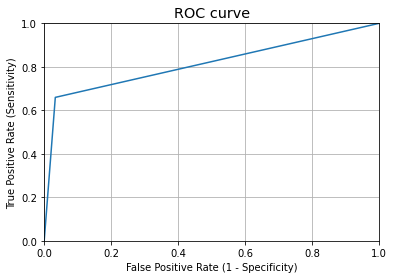

In [143]:
lr = LogisticRegression()
train_classification_model(lr)


### XGBClassifier

  0%|          | 0/5 [00:00<?, ?it/s]

Training on fold 0
[10:23:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 1/5 [00:00<00:01,  3.05it/s]

class distribution check: 474
[0 0 0 0 1]
Training on fold 1
[10:23:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 2/5 [00:00<00:00,  3.24it/s]

class distribution check: 474
[0 0 0 0 1]
Training on fold 2
[10:23:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 3/5 [00:00<00:00,  3.39it/s]

class distribution check: 474
[1 0 0 0 0]
Training on fold 3
[10:23:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [00:01<00:00,  3.62it/s]

class distribution check: 473
[0 0 0 1 0]
Training on fold 4
[10:23:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

class distribution check: 473
[0 0 1 0 0]
Mean Accuracy validation set: 0.9998098256735339
Mean Precision validation set: 0.9987359538085719
Mean Recall val set: 1.0
Mean F1 validation set: 0.9993673104462765
Mean Accuracy train set: 1.0
Mean Precision train set: 1.0
Mean Recall train set: 1.0
Mean F1 train set: 1.0
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2682
           1       1.00      1.00      1.00       473

    accuracy                           1.00      3155
   macro avg       1.00      1.00      1.00      3155
weighted avg       1.00      1.00      1.00      3155

Confusion matrix: 
 [[2682    0]
 [   0  473]]
value counts: 473


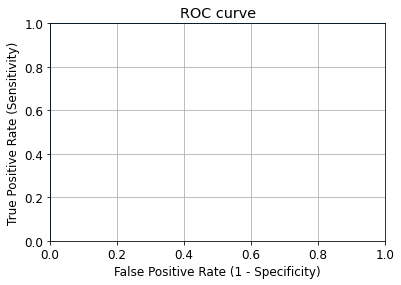

In [144]:
xgb = XGBClassifier()
train_classification_model(xgb)

Well, XGBClassifier is doing well with the precision and recall are about 99% but I have seen the imbalance in the class distribution. So, I have to check for individual class metrics to verify model is performing better on the highly represented class and poorly on the less represented class. I'll check this by adding classification report and the confusion matrix to my training function.

After checking at the classification report and confusion matrix, it looks that the imbalance has no effect on the training process. In case the model has bias towards the most represented class `random_over_sampling` method can be used for over sampling.

### Evaluating model2 on model 1 results

In [104]:
predictions_reg = joblib.load('linear_regression_prediction.pkl')
X_test = pd.DataFrame(predictions_reg, columns = targets_reg)

In [145]:
X_test, Y_test = get_test_data('classification')
predictions = xgb.predict(X_test)
print("Classification Report: \n", classification_report(Y_test, predictions))
print("Confusion matrix: \n", confusion_matrix(Y_test, predictions))
compare_predictions(Y_test.H.tolist()[:10], predictions[:10])

# save model and predictions
joblib.dump(model, "xgboost_classifier.pkl")
joblib.dump(predictions, "xgboost_classifier_predictions.pkl")


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3388
           1       1.00      1.00      1.00       556

    accuracy                           1.00      3944
   macro avg       1.00      1.00      1.00      3944
weighted avg       1.00      1.00      1.00      3944

Confusion matrix: 
 [[3387    1]
 [   0  556]]
0 0
0
0 0
0
0 0
0
0 0
0
0 0
0
0 0
0
0 0
0
0 0
0
0 0
0
0 0
0


['xgboost_classifier_predictions.pkl']

## Conclusion

After carefully checking random predictions and based on the metrics final predictions looks pretty good.
Although, there are few small errors in the regression model predictions however it doesn't really making any effect in claffication results.

Note: I have used `jupyter/datascience-notebook` docker image to complete the challenge because it has most of the libraries to perform the task. In case if you are running Jupyter notebook in your local machine you have to install all the packages(numpy, pandas, matplotlib, scipy etc).

To run docker container with mounting a directory.

`docker run -p 8888:8888 -v $PWD:/home/jovyan/work jupyter/datascience-notebook:latest`




In [10]:


print([print(X, end=',') for X in range(5)[-3::-1]])

2,1,0,[None, None, None]


In [4]:
import numpy as np
np.log(0)

np.sqrt(0.1386136852)

/tmp/ipykernel_58/3573331748.py:2: RuntimeWarning: divide by zero encountered in log
  np.log(0)


0.37230858867342825